<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [7]:
df.head(5), df.shape

(      Burrito       Date  Yelp  Google Chips  ...  Sushi  Avocado  Corn  Zucchini  Great
 0  California  1/18/2016   3.5     4.2   NaN  ...    NaN      NaN   NaN       NaN  False
 1  California  1/24/2016   3.5     3.3   NaN  ...    NaN      NaN   NaN       NaN  False
 2    Carnitas  1/24/2016   NaN     NaN   NaN  ...    NaN      NaN   NaN       NaN  False
 3       Asada  1/24/2016   NaN     NaN   NaN  ...    NaN      NaN   NaN       NaN  False
 4  California  1/27/2016   4.0     3.8     x  ...    NaN      NaN   NaN       NaN   True
 
 [5 rows x 59 columns], (421, 59))

In [8]:
display(df.isna().sum())
# Get the list of features which have more than a 100 NaN values
noisy_features = df.columns[df.isna().sum() > 100].tolist()
display(noisy_features)
# Drop all the noisy features
df = df.drop(columns=noisy_features)

Burrito             0
Date                0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple 

['Yelp',
 'Google',
 'Chips',
 'Mass (g)',
 'Density (g/mL)',
 'Length',
 'Circum',
 'Volume',
 'Unreliable',
 'NonSD',
 'Beef',
 'Pico',
 'Guac',
 'Cheese',
 'Fries',
 'Sour cream',
 'Pork',
 'Chicken',
 'Shrimp',
 'Fish',
 'Rice',
 'Beans',
 'Lettuce',
 'Tomato',
 'Bell peper',
 'Carrots',
 'Cabbage',
 'Sauce',
 'Salsa.1',
 'Cilantro',
 'Onion',
 'Taquito',
 'Pineapple',
 'Ham',
 'Chile relleno',
 'Nopales',
 'Lobster',
 'Queso',
 'Egg',
 'Mushroom',
 'Bacon',
 'Sushi',
 'Avocado',
 'Corn',
 'Zucchini']

In [9]:
display(df.head(5))
df.shape

,Burrito,Date,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,1/18/2016,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,California,1/24/2016,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,Carnitas,1/24/2016,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,Asada,1/24/2016,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,California,1/27/2016,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True


(421, 14)

In [10]:


df.Date = df.Date.astype('datetime64[ns]')
df.head(5)

,Burrito,Date,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,2016-01-18,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,California,2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,Carnitas,2016-01-24,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,Asada,2016-01-24,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,California,2016-01-27,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True


In [11]:
#Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

df_train = df[df.Date < 'January 2017' ]
df_val   = df[(df.Date >= 'January 2017') & (df.Date < 'January 2018')]
df_test  = df[df.Date >= 'January 2018']

df_train.shape, df_val.shape, df_test.shape

((298, 14), (85, 14), (38, 14))

In [12]:
display(df_train.Great.value_counts())
df_train.Great.mode()

False    176
True     122
Name: Great, dtype: int64

0    False
dtype: bool

In [13]:
#Begin with baselines for classification.

dcols = ['Date', 'Great']
target = 'Great'

X_train = df_train.drop(columns=dcols)
X_val   = df_val.drop(columns=dcols)
X_test  = df_test.drop(columns=dcols)

y_train = df_train[target]
y_val   = df_val[target]
y_test  = df_test[target]

y_bl = [y_train.mode()[0]] * len(y_val)


In [14]:
from sklearn.metrics import accuracy_score

# Compute accuracy score for baseline
accuracy_score(y_val, y_bl)

0.5529411764705883

In [15]:
display(X_train.describe(exclude='number'))
X_train.Burrito.isna().sum()

,Burrito
count,298
unique,5
top,California
freq,118


0

In [16]:
# Burrito is the only categorical feature and it has no NaN values
import category_encoders as ce

# Perform One Hot Encoding of categorical feature Burrito
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [17]:
# Impute missing values using SimpleImputer - default strategy is mean
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

In [18]:
# Scale x values using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [19]:
# Use scikit-learn for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

log_reg = LogisticRegressionCV()
log_reg.fit(X_train_scaled, y_train)
print('Validation Accuracy', log_reg.score(X_val_scaled, y_val))



Validation Accuracy 0.8705882352941177


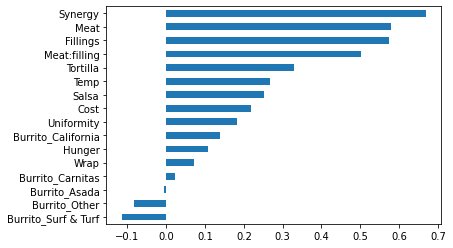

In [20]:
# Get and plot model(log_reg) coefficients.
coefficients = pd.Series(log_reg.coef_[0], X_train.columns)
coefficients.sort_values().plot.barh(); #bar charts


In [21]:
print('Test Accuracy', log_reg.score(X_test_scaled, y_test))

Test Accuracy 0.7631578947368421


In [22]:
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# For parameter k, use SelectKBest to compute the k best
# features and use those to train a LogisticRegressionCV
# model.
def select_and_fit(k):
    
  selector = SelectKBest(score_func=f_classif, k=k)
  X_train_selected = selector.fit_transform(X_train_scaled, y_train)
  X_val_selected = selector.transform(X_val_scaled)

  model = LogisticRegressionCV()
  model.fit(X_train_selected, y_train)
  
  return model.score(X_val_selected, y_val), list(X_train.columns[selector.get_support()]), model, selector

best_model = None
best_selector = None
best_features=[]
best_k = 0
best_acc = 0
# Loop through k from 1 to 47 and compare MAEs to determine the best
# k features(best_features) with the lowest MAE
for k in range(1, len(X_train.columns)+1):
    acc, feat, model, selector = select_and_fit(k)
    #print(acc, feat)
    if acc > best_acc:
      best_acc = acc
      best_k = k
      best_features = feat
      best_model = model
      best_selector = selector
    #print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

print(f'best_k = {best_k}\nbest Accuracy = {best_acc:0.4f}\nbest features = {best_features}')

best_k = 3
best Accuracy = 0.9176
best features = ['Meat', 'Fillings', 'Synergy']


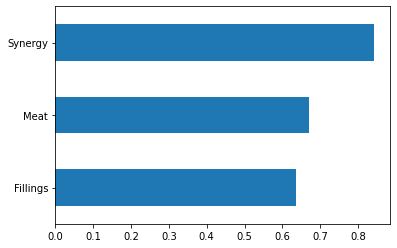

In [25]:
# Get and plot model(log_reg) coefficients.
coefficients = pd.Series(best_model.coef_[0], best_features)
coefficients.sort_values().plot.barh(); #bar charts

In [23]:
print('Test Accuracy', best_model.score(best_selector.transform(X_test_scaled), y_test))

Test Accuracy 0.7105263157894737
